<h2>Мастерская. Прогноз успешных стартапов<a class="tocSkip"></h2>
<h3>Цель проекта<a class="tocSkip"></h3>
Разработать модель для предсказания успешности стартапа (закроется или нет).

Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на Kaggle.

<h3>Описание данных<a class="tocSkip"></h3>

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- `kaggle_startups_train_01.csv` - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- `kaggle_startups_test_01.csv` - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
- `kaggle_startups_sample_submit_01.csv` - файл с примером предсказаний в правильном формате.
- `name` - идентификатор (название) стартапа в тестовом наборе.
- `status` - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].

<h3>Описание полей данных<a class="tocSkip"></h3>

- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий)
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

<h3>Ход работы <a class="tocSkip"></h3>
    
- Загрузка и ознакомление с данными,
- Предварительная обработка,
- Полноценный разведочный анализ,
- Разработка новых синтетических признаков,
- Проверка на мультиколлинеарность,
- Отбор финального набора обучающих признаков,
- Выбор и обучение моделей,
- Итоговая оценка качества предсказания лучшей модели,
- Анализ важности ее признаков,
- Подготовка отчета по исследованию.

In [1]:
# Работа с файлами и системными путями
import os  # Работа с операционной системой и файловыми путями
import warnings  # Управление предупреждениями
warnings.filterwarnings("ignore")    
import tqdm as notebook_tqdm # Новые шкалы прогресса
#импортируем используемые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
# Работа с пропусками
import missingno as msno
#Работа с датой и временем
from datetime import datetime

#библиотека для расчета коэффициентов корреляции Фи
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

import sklearn

# для разделения выборки
from sklearn.model_selection import train_test_split

# Создание пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# кодировщики
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    LabelEncoder,
    RobustScaler
)

# инструмент для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# метрики
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, 
    recall_score, precision_score,
    f1_score                        
    )

# импортируем модели
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier  # Энсамблевые методы
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif  # Отбор признаков
import xgboost as xgb  # XGBoost модель
import lightgbm as lgb  # LightGBM модель
import catboost as cb  # CatBoost модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
# Анализ важности признаков
from sklearn.inspection import permutation_importance
import shap

In [2]:
#Для загрузки с яндекс диска
import requests
import urllib
import json
import zipfile
from urllib.parse import urlencode

In [3]:
import joblib

In [4]:
import optuna
from optuna import distributions
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

In [5]:
#Константы
#Я просто любитель комикса, поэтому 42 :)
RANDOM_STATE = 42

#Выборку будем делить в отношении 3:1 - 3 обучающей, 1 доля тестовой
TEST_SIZE = 0.25

<h2><b>Оглавление</b><a class="tocSkip"></h2>

<a href='#Step0'><b>Функции, используемые в проекте</b></a>   
    
<a href='#Step1'><b>1. Загрузка данных</b></a>
    
<a href='#Step2'><b>2. Предобработка данных</b></a>
- <a href='#Step2.1'><b>2.1 Создание столбца lifetime для тренировочной выборки</b></a>
- <a href='#Step2.2'><b>2.2 Заполнение пропусков</b></a>
- <a href='#Step2.3'><b>2.3 Проверка на наличие аномалий</b></a>
- <a href='#Step2.4'><b>2.4 Укрупнение категорий</b></a>
- <a href='#Step2.4'><b>2.5 Вывод по разделу</b></a>

<a href='#Step3'><b>3. Исследовательский анализ</b></a>
- <a href='#Step3.1'><b>3.1 Распределение данных в `df_train`</b></a>
- <a href='#Step3.2'><b>3.2 Распределение данных в `df_test`</b></a>
- <a href='#Step3.3'><b>3.3 Вывод по разделу</b></a>

<a href='#Step4'><b>4. Разработка новых синтетических признаков</b></a>
- <a href='#Step4.1'><b>4.1 Добавиление синтетических признаков</b></a>
- <a href='#Step4.2'><b>4.2 Вывод по разделу</b></a>

<a href='#Step5'><b>5. Корреляционный анализ</b></a>
- <a href='#Step5.1'><b>5.1 Расчет коэффициентов корреляции</b></a>
- <a href='#Step5.2'><b>5.2 Отбор финального набора обучающих признаков</b></a>
- <a href='#Step5.3'><b>5.3 Вывод по разделу</b></a>

<a href='#Step6'><b>6. Обучение модели и получение результатов</b></a>
- <a href='#Step6.1'><b>6.1 Подготовка признаков¶</b></a>
- <a href='#Step6.2'><b>6.2 Обучение модели</b></a>
- <a href='#Step6.3'><b>6.3 Применение модели на тестовой выборке</b></a>

<a href='#Step7'><b>7. Анализ важности признаков</b></a>

<a href='#Step8'><b>8. Обший вывод</b></a>

<a id='Step0'></a>
<h3><b> Функции, используемые в проекте<a class="tocSkip"></h3>

In [6]:
#Функция для отображения основной информации по датафрейму и количество пропусков

def check_df (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'Общая информация по датафрейму {df_name}:')
        # общая информация
        df.info()
        # описательная статистика
        display(df.describe())
        # первые 5 строк
        display(df.head())
        print()
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [7]:
#Функция проверки на пропущенные значения и явные дубликаты

def check_isna_dupl (dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(f'В датафрейме {df_name}:')
        print(f'Количество пропущенных значений:\n{df.isna().sum()} \
        \nКоличество явных дубликатов: {df.duplicated().sum()}')
        print()

In [8]:
def load_data (file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, sep=',')
        print('Данные успешно загружены')
        return df
    else:
        print('Something is wrong')

In [9]:
#Функция построения графика гистограмм распределения

def histogram(df, col, target, lim):
    sns.histplot(df, bins=20, kde=True, hue=target, x=col, xlim=c(0, 100))
    plt.title(f'Рапределение по {col}', fontsize=16)
    plt.ylabel('Количество', fontsize=14)

In [10]:
#Функция построения графика распределения признаков

def categoral_unique(df, col, target):   
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df, hue=target)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

<a id='Step1'></a>
<h3><b> 1. Загрузка данных<a class="tocSkip"></h3>

In [11]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/S7T7aTJQCKuv4g'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('./Datasets.zip', 'wb') as f:
    f.write(download_response.content)

zip_path = ('./Datasets.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./Datasets')

In [12]:
train_pth = './Datasets/M1_DS - Startups (STD)/kaggle_startups_train_28062024.csv'
test_pth = './Datasets/M1_DS - Startups (STD)/kaggle_startups_test_28062024.csv'
submit_pth = './Datasets/M1_DS - Startups (STD)/kaggle_startups_sample_submit_28062024.csv'

In [13]:
df_train = load_data(train_pth)
df_test = load_data(test_pth)
df_submit = load_data(submit_pth)

Данные успешно загружены
Данные успешно загружены
Данные успешно загружены


In [14]:
check_df([df_train, df_test])

Общая информация по датафрейму df_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN



В датафрейме df_train:
Количество пропущенных значений:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64         
Количество явных дубликатов: 0

Общая информация по датафрейму df_test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



В датафрейме df_test:
Количество пропущенных значений:
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64         
Количество явных дубликатов: 0



Визуализируем пропуски в тренировочном и тестовом датафреймах

Пропущенные значения в тренировочном наборе данных
name                     1
category_list         2465
funding_total_usd    10069
country_code          5502
state_code            6763
region                6359
city                  6359
closed_at            47599
dtype: int64


Визуализация пропусков


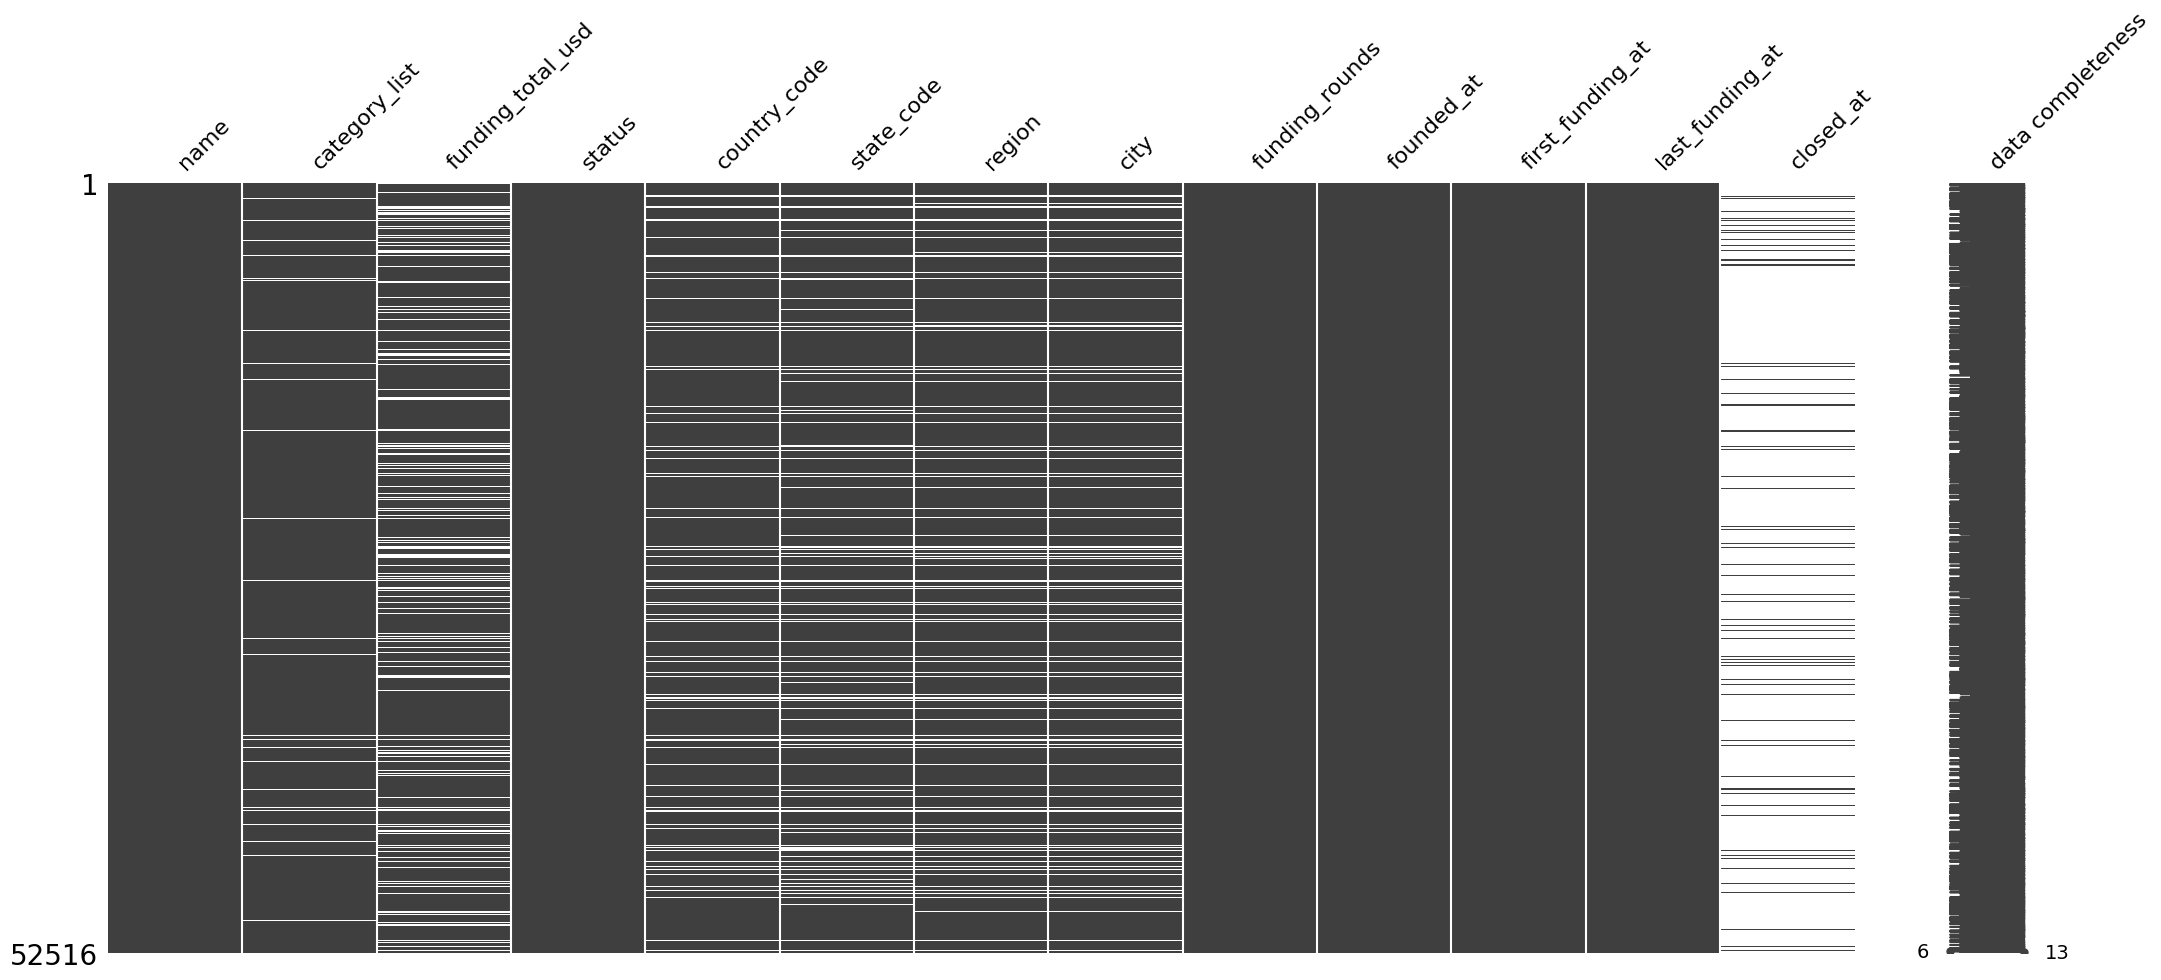

In [15]:
# Проверка на пропуски в тренировочном наборе данных
print('Пропущенные значения в тренировочном наборе данных')
missing_train = df_train.isnull().sum()
print(missing_train[missing_train > 0])
print("\n")
print('Визуализация пропусков')
msno.matrix(df_train, labels=True)
plt.show()

Пропущенные значения в тестовом наборе данных
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
dtype: int64


Визуализация пропусков


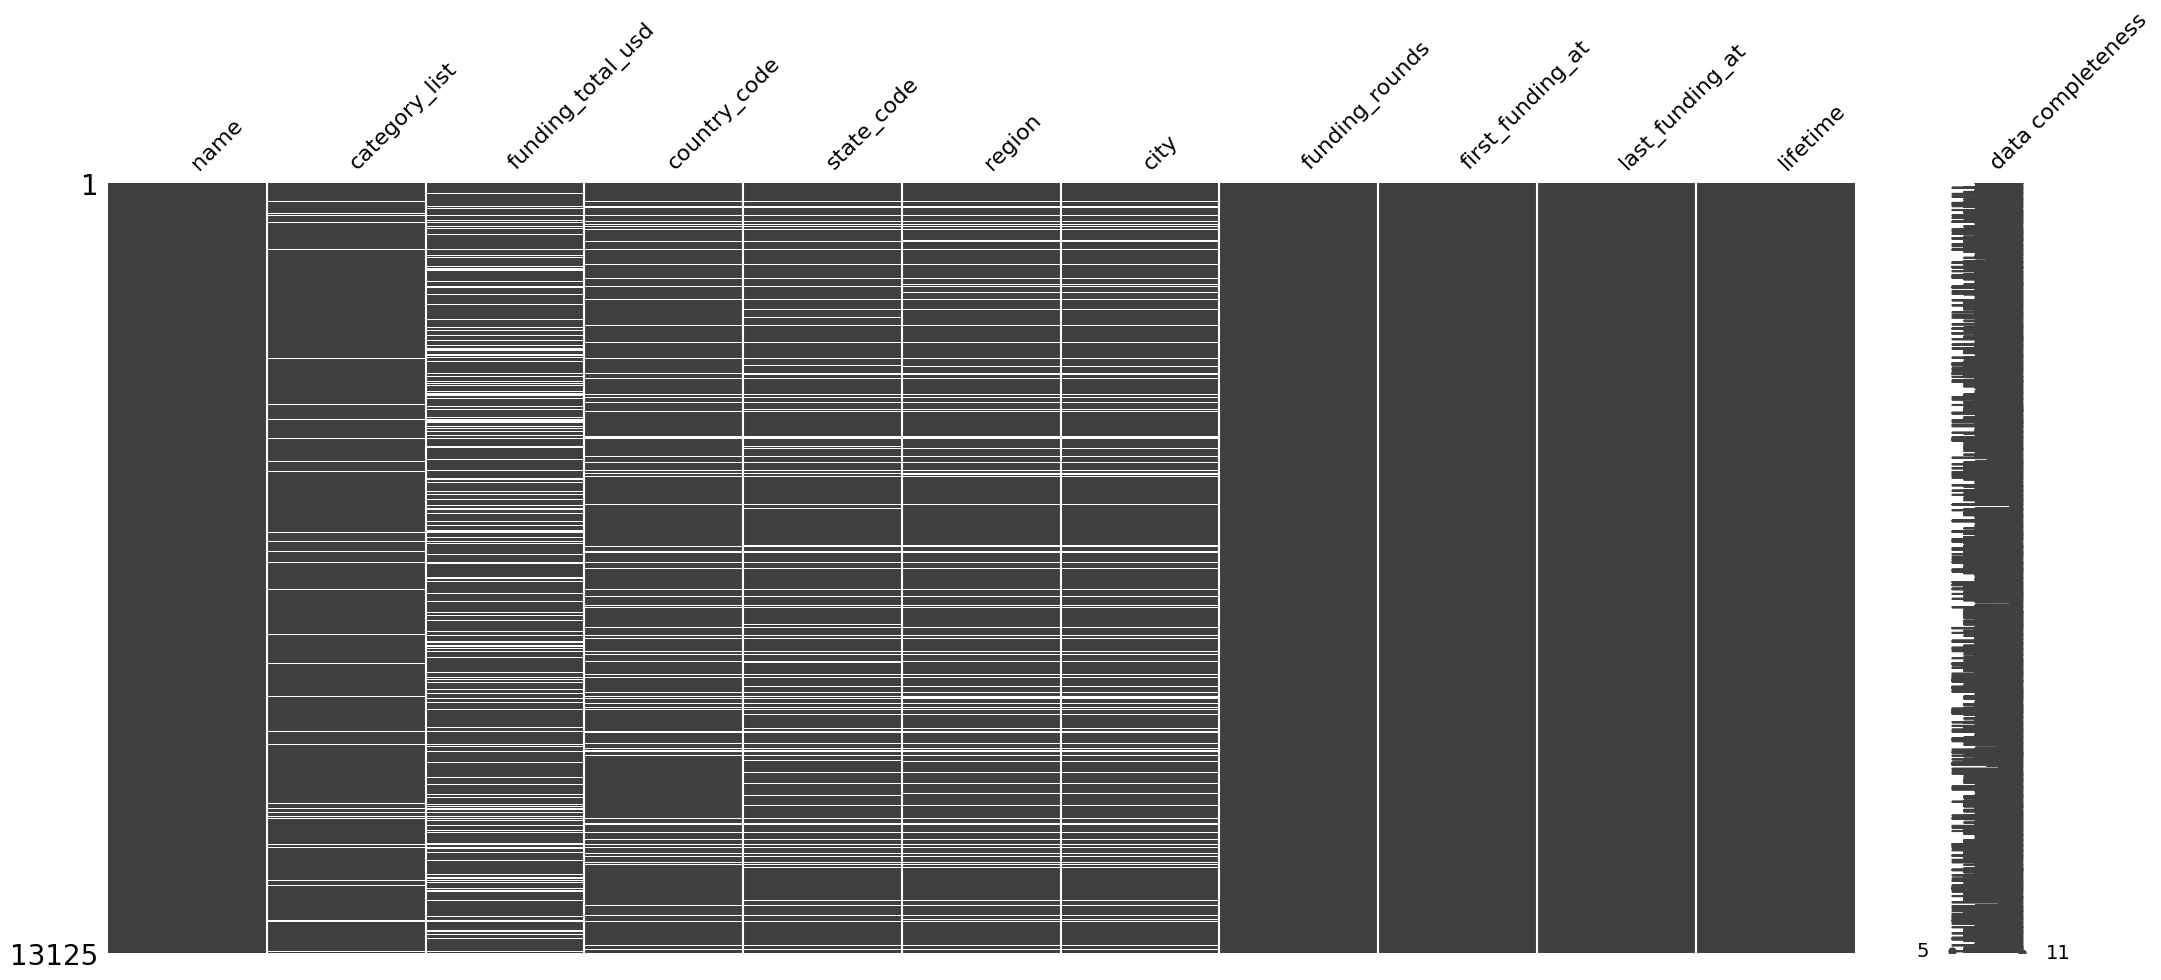

In [16]:
print('Пропущенные значения в тестовом наборе данных')
missing_test = df_test.isnull().sum()
print(missing_test[missing_test > 0])
print("\n")
print('Визуализация пропусков')
msno.matrix(df_test, labels=True)
plt.show()

**Промежуточный вывод**

- `df_train` (тренировочная выборка) 52516 записи и 13 столбцов
- `df_test` (тестовая выборка) 13125 записи и 11 столбцов

- В датасетах представлены категориальные и количественные признаки
- В обоих датасетах присутствуют пропущенные значения. Пропущенные категориальные значения заполним либо часто встречающимися, либо `Unknown`. Количественные будем заполнять либо медианой, либо средним значением.
- Аномалий в датасетах не обнаружили
- Явные дубликаты отсутствуют

**Заполнение пропусков будем делать в процессе создания пайплайна**

<a id='Step2'></a>
<h3><b> 2. Предварительная обработка<a class="tocSkip"></h3>

Для обучения модели в тренировочной выборке отсутствует столбец lifetime, который присутствует в тестовой. 

- Стартапы, где отсутствуют значения 'closed_at' будем считать работающими - из текущей (последняя дата выборки) вычтем дату основания.
- Для остальных стартапов посчитаем разницу между закрытием и основанием и отобразим в днях

<a id='Step2.1'></a>
<h4><b> 2.1 Создание столбца lifetime для тренировочной выборки<a class="tocSkip"></h4>

In [17]:
#df_train['founded_at'] = pd.to_datetime(df_train['founded_at'], format='%Y-%m-%d')
#df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format='%Y-%m-%d')

In [18]:
#Вычисление lifetime для двух случаев
def lifetime_insert(row, last_date):
    try:
        founded_at = datetime.strptime(row['founded_at'], '%Y-%m-%d')
    except:
        return (last_date - datetime.strptime('1970-01-01', '%Y-%m-%d')).days
    if pd.notnull(row['closed_at']):
        try:
            closed_at = datetime.strptime(row['closed_at'], '%Y-%m-%d')
            return (closed_at - founded_at).days
        except:
            return (last_date - founded_at).days
    else:
        return (last_date - founded_at).days
#Последняя дата датафрейма (дата окончания выборки)        
last_date = datetime.strptime('2018-01-01', '%Y-%m-%d')
#Применяем функцию и создаем столбец
df_train['lifetime'] = df_train.apply(lambda row: lifetime_insert(row, last_date), axis=1)
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2791


In [19]:
df_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


**Пропуски в данных заполним в пайплайне:**
- Пропущенные данные в столбце `category_list`, `country_code`, `state_code`, `region`, `city` в обоих датасетах заполним значением `Unknown`
- Пропущенные данные в столбце `funding_total_usd` в обоих датасетах заполним медианным значением по группам, для тех строк, где не будет групп заполним медианным значением всего датасета

<a id='Step2.2'></a>
<h4><b> 2.2 Заполнение пропусков<a class="tocSkip"></h4>

Заполним пропуски в категориальных признаках на Unknown

In [20]:
def missing_data_row(df, columns):
    for column in columns:
        df[column] = df_train[column].fillna('Other')
columns_to_insert = ['category_list', 'country_code', 'state_code', 'region', 'city']

In [21]:
missing_data_row(df_train, columns_to_insert)
missing_data_row(df_test, columns_to_insert)

In [22]:
df_train['name'] = df_train['name'].fillna('Other')

Заполняем пропуски в `funding_total_usd` признаках

In [23]:
def missing_median(df, group_columns, target_column='funding_total_usd'):
    global_median = df[target_column].median()
    def fill_row(row):
        if pd.isnull(row[target_column]):
            # Ищем не пустые значения в столбцах группы
            for col in group_columns:
                if pd.notnull(row[col]):
                    # Группируем по текущему столбцу и заполняем медианой
                    group_median = df.groupby(col)[target_column].transform('median')
                    
                    # Проверяем, является ли медиана для данной строки NaN
                    if pd.isna(group_median[row.name]):
                        continue
                    return group_median[row.name]
            
            # Если все столбцы группы пустые или медиана NaN, заполняем глобальной медианой
            return global_median
        else:
            return row[target_column]
    
    # Применяем функцию ко всем строкам DataFrame
    df[target_column] = df.apply(fill_row, axis=1)

In [24]:
missing_median(df_train, ['country_code','state_code','region','city','funding_rounds'])
missing_median(df_test, ['country_code','state_code','region','city','funding_rounds'])

In [25]:
print('Количество пропущенных значений в df_train \n', 
      df_train.isna().sum())
print()
print('Количество пропущенных значений в df_test \n',
      df_test.isna().sum())

Количество пропущенных значений в df_train 
 name                     0
category_list            0
funding_total_usd        0
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
lifetime                 0
dtype: int64

Количество пропущенных значений в df_test 
 name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64


<a id='Step2.3'></a>
<h4><b> 2.3 Проверка на явные дубликаты<a class="tocSkip"></h4>

Повторно проверим на наличие явных дубликатов после заполнения пропусков

In [26]:
print(f'Количество явных дубликатов в df_train: {df_train.duplicated().sum()}')
print(f'Количество явных дубликатов в df_test: {df_test.duplicated().sum()}')

Количество явных дубликатов в df_train: 0
Количество явных дубликатов в df_test: 0


<a id='Step2.4'></a>
<h4><b> 2.4 Укруплнение категорий<a class="tocSkip"></h4>

In [27]:
df_train['category_list'].nunique()

22106

При пробном обучении модели с существующими категориями обнаружена проблема неадекватно долгого обработки данных из-за большого количества уникальных значений в категориальных признаках.
Нужно укрупнить категории в тех строках, где указано несколько категорий для одного стартапа

In [28]:
top_100_cat = df_train['category_list'].value_counts().head(100).index.tolist()

In [29]:
def top_category_to_plot(df, category_list, country_list, region_list):
    # Создадим функцию для укрупнения категорий, чтобы построить графики

    categories = category_list.str.split('|')
    # Замена всех значений, кроме 10 самых частых, на 'other'
    top_10 = df['category_list'].value_counts().index[:10]
    df['top_cat_to_plot'] = df['category_list'].apply(lambda x: x if x in top_10 else 'other')
        
    # Создадим функцию для укрупнения категорий стран, чтобы построить графики
    # Замена всех значений, кроме 10 самых частых, на 'other'
    top_10 = df['country_code'].value_counts().index[:10]
    df['country_code_to_plot'] = df['country_code'].apply(lambda x: x if x in top_10 else 'other')
    
    # Создадим функцию для укрупнения категорий регионов, чтобы построить графики
    # Замена всех значений, кроме 15 самых частых, на 'other'
    top_10 = df['region'].value_counts().index[:15]
    df['region_to_plot'] = df['region'].apply(lambda x: x if x in top_10 else 'other')
        
    return df

In [30]:
df_train = top_category_to_plot(df_train, df_train['category_list'], df_train['country_code'], df_train['region'])
df_test = top_category_to_plot(df_test, df_test['category_list'], df_test['country_code'], df_test['region'])

In [31]:
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,top_cat_to_plot,country_code_to_plot,region_to_plot
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2998,other,other,other
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,4748,other,USA,SF Bay Area
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,4383,Biotechnology,USA,SF Bay Area
3,Sancilio and Company,Health Care,22250000.0,operating,Other,Other,Other,Other,3,2004-01-01,2011-09-01,2014-07-18,NaN,5114,Health Care,Other,Other
4,WireTough Cylinders,Manufacturing,3000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2791,other,USA,other


In [32]:
df_train['region_to_plot'].value_counts()

region_to_plot
other               24917
SF Bay Area          6970
Other                6359
New York City        2776
Boston               1890
London               1840
Los Angeles          1513
Seattle               955
Washington, D.C.      817
Chicago               778
San Diego             703
Austin                652
Denver                638
Toronto               591
Tel Aviv              571
Paris                 546
Name: count, dtype: int64

<a id='Step2.5'></a>
<h4><b> 2.5 Вывод по разделу<a class="tocSkip"></h4>

- Заполнили пропуски в категориальных данных на Unknown
- Пропуски в количественной признаке `funding_total_usd` заполнили медианой
- Укрупнили категорию, так как изначально было 22106 уникальных значений, что очень усложняет и увеличивает время обучения модели - уменьшили до 127 уникальных значений в тренировочной выборке

<a id='Step3'></a>
<h3><b> 3. Исследовательский анализ<a class="tocSkip"></h3>

<a id='Step3.1'></a>
<h4><b> 3.1 Распределение данных в df_train<a class="tocSkip"></h4>

Распределение количественного признака `funding_total_usd`

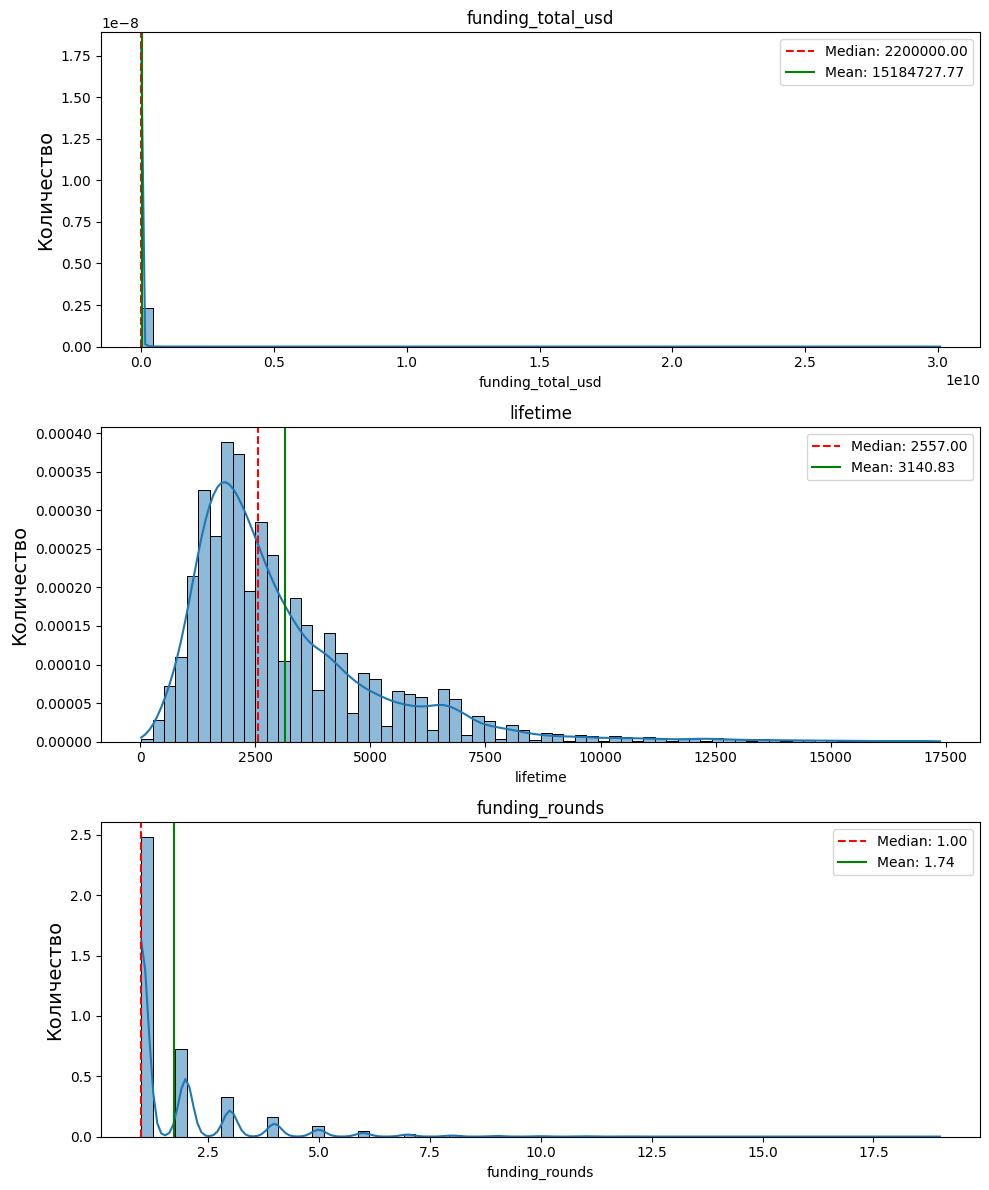

In [33]:

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'funding_total_usd', 'lifetime', 'funding_rounds'
]):
    sns.histplot(data=df_train, ax=axes[i], 
                 x=column, bins=70, kde=True, stat='density', common_norm=False)
    
    #Расчет среднего и медианы
    median_value = df_train[column].median()
    mean_value = df_train[column].mean()
    axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    axes[i].legend()
    axes[0].legend(loc='upper right')

# Показать графики
plt.tight_layout()
plt.show();

**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО РАСПРЕДЕЛЕНИЮ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ**

1. `funding_total_usd`
   - Данные распределены ненормально
   - Основная масса значений лежит в пределах медианы 2200000
   - Небольшая часть стартапов получили намного больше денег 10000000000 USD

2. `lifetime`
    - Данные распределены практически нормально, со смещением влево
    - В основном возраст стартапа около 2500 дней
    - Также присутствуют долгожители - 17000 дней
    - Средний возраст стартапа 3140 дня

3. `funding_rounds`
    - Ненормальное распределение со смещением влево
    - Практически все компании прошли первый раунд
    - Максимальное число раундов, которые прошли стартапы `19`

In [34]:
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,top_cat_to_plot,country_code_to_plot,region_to_plot
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2998,other,other,other
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN,4748,other,USA,SF Bay Area
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,4383,Biotechnology,USA,SF Bay Area
3,Sancilio and Company,Health Care,22250000.0,operating,Other,Other,Other,Other,3,2004-01-01,2011-09-01,2014-07-18,NaN,5114,Health Care,Other,Other
4,WireTough Cylinders,Manufacturing,3000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2791,other,USA,other


**Распределение категориальных данных**

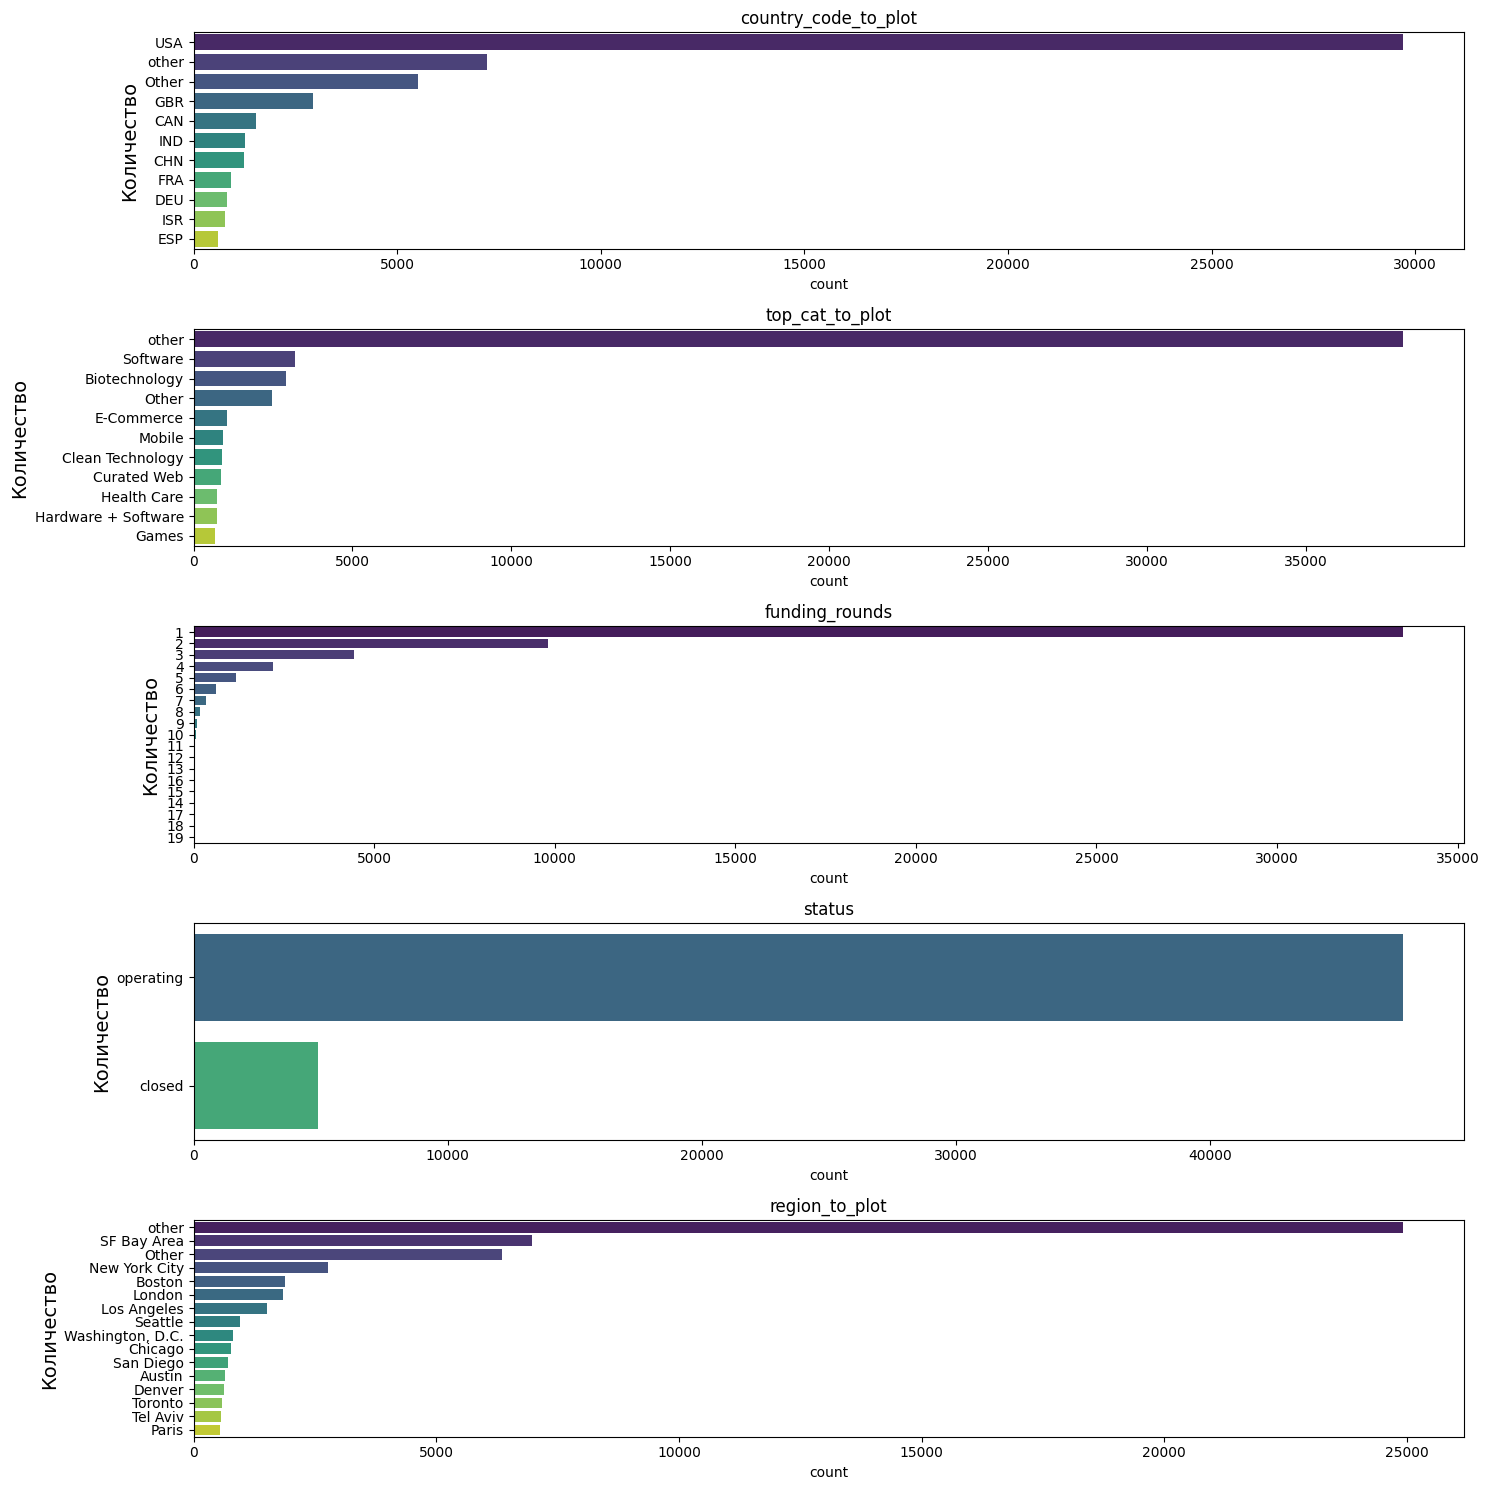

In [35]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'country_code_to_plot', 'top_cat_to_plot', 'funding_rounds', 'status', 'region_to_plot'
]):
    sns.countplot(data=df_train, ax=axes[i], 
                 y=column, order=df_train[column].value_counts().index,
                 palette='viridis')
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    #axes[i].legend()
    #axes[0].legend(loc='upper right')   
    
# Показать графики
plt.tight_layout()
plt.show();

**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО РАСПРЕДЕЛЕНИЮ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ**

1. `country_code`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 стран и остальным присвоено `Others` для удобства отображения
   - Основная масса стартапов из `USA`
   - Для большой части стартапов неизвестна страна происхождения - им просвоено значение `Unknown`

2. `category_list`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 категорий и остальным присвоено `Others` для удобства отображения
    - Топ категориями являются `Software`, `Biotechnology` и `E-Commerce`
    - Неизвестным/пропущенным значением (которыме могли возникнуть вследствие утечки данных) присвоены значения `Unknown`

3. Целевой признак `status`
    - Сильный дисбаланс данных, работающий стартапов намного больше, чем закрытых

<a id='Step3.2'></a>
<h4><b> 3.2 Распределение данных в df_test<a class="tocSkip"></h4>

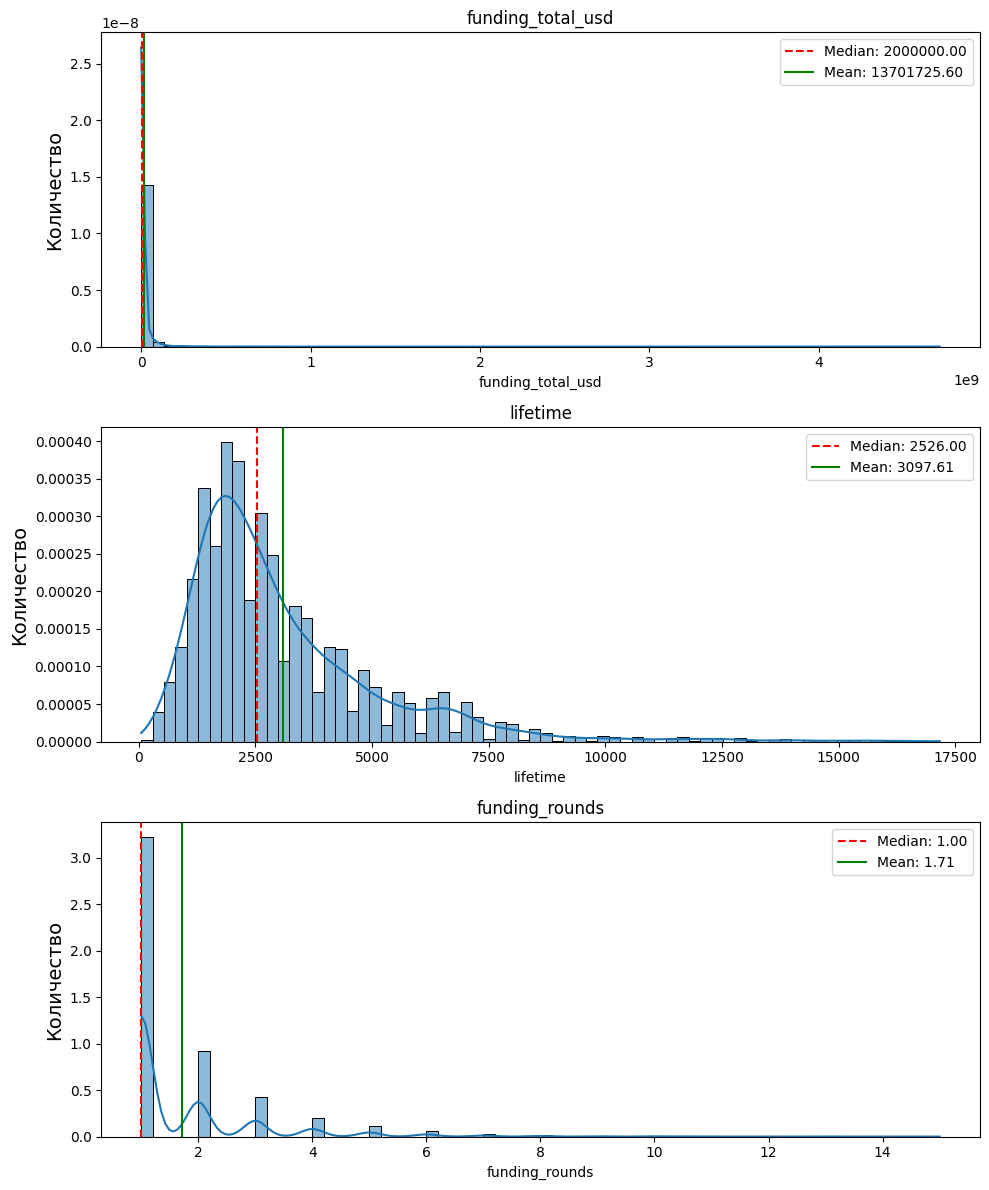

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'funding_total_usd', 'lifetime', 'funding_rounds'
]):
    sns.histplot(data=df_test, ax=axes[i], 
                 x=column, bins=70, kde=True, stat='density', common_norm=False)
    
    #Расчет среднего и медианы
    median_value = df_test[column].median()
    mean_value = df_test[column].mean()
    axes[i].axvline(median_value, color='r', linestyle='--', label=f'Median: {median_value:.2f}')
    axes[i].axvline(mean_value, color='g', linestyle='-', label=f'Mean: {mean_value:.2f}')
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    axes[i].legend()
    axes[0].legend(loc='upper right')

# Показать графики
plt.tight_layout()
plt.show();

**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО РАСПРЕДЕЛЕНИЮ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ**

1. `funding_total_usd`
   - Данные распределены ненормально
   - Основная масса значений лежит в пределах медианы 2000000
   - Небольшая часть стартапов получили намного больше денег 1000000000 USD

2. `lifetime`
    - Данные распределены практически нормально, со смещением влево
    - В основном возраст стартапа около 2500 дней
    - Также присутствуют долгожители - 17000 дней
    - Средний возраст стартапа 3097 дней

3. `funding_rounds`
    - Ненормальное распределение со смещением влево
    - Практически все компании прошли первый раунд
    - Максимальное число раундов, которые прошли стартапы `15`


**Распределение данных в тестовом датасете практически идентичное распределнию данных в тренировочном датасете**

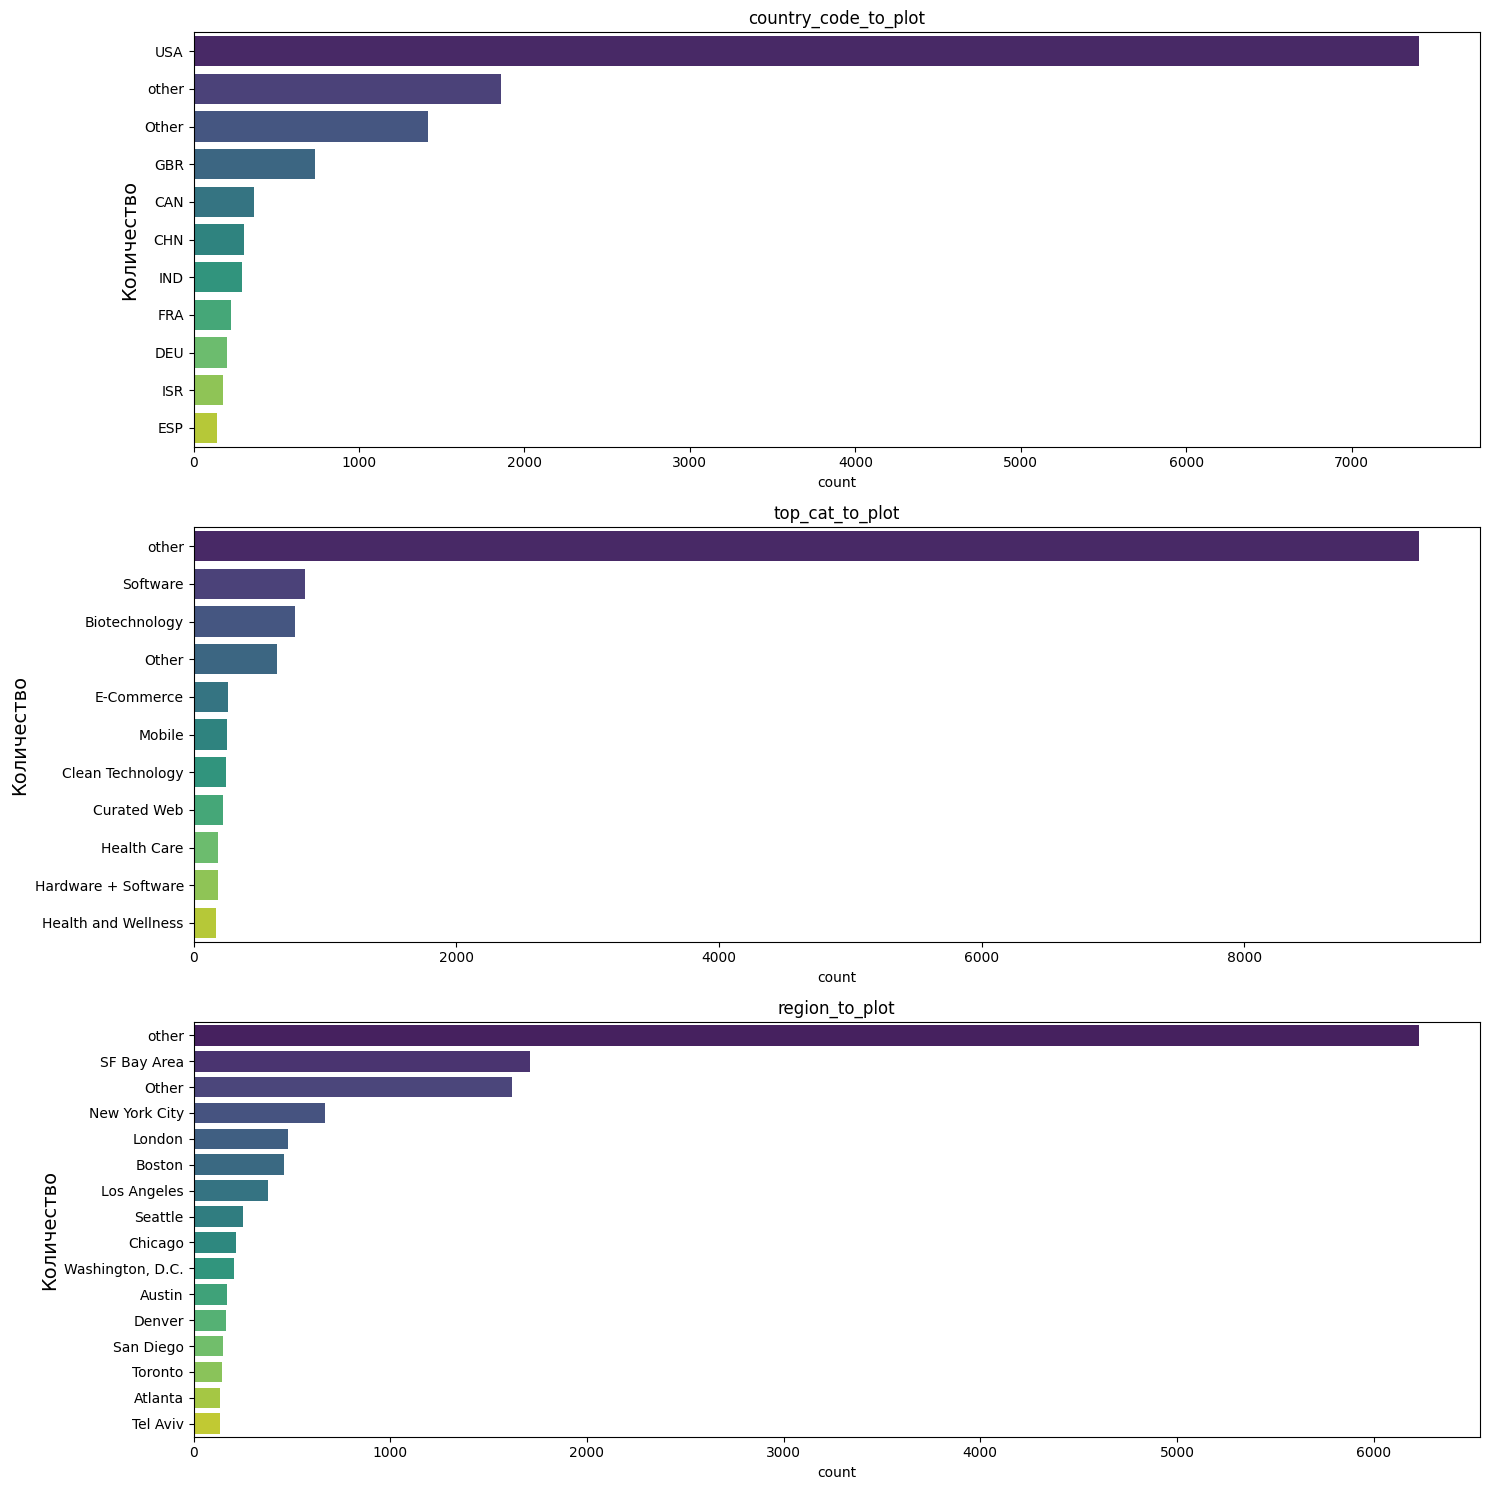

In [37]:
# Создание графика с 8 подграфиками в два столбца
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Преобразование 2D массива подграфиков в 1D для удобного индексирования
axes = axes.ravel()

# Построение гистограмм
for i, column in enumerate([
    'country_code_to_plot', 'top_cat_to_plot', 'region_to_plot'
]):
    sns.countplot(data=df_test, ax=axes[i], 
                 y=column, order=df_test[column].value_counts().index,
                 palette='viridis')
    axes[i].set_title(column)
    axes[i].set_ylabel('Количество', fontsize=14)
    #axes[i].legend()
    #axes[0].legend(loc='upper right')   
    
# Показать графики
plt.tight_layout()
plt.show();

**ПРОМЕЖУТОЧНЫЙ ВЫВОД ПО РАСПРЕДЕЛЕНИЮ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ**

1. `country_code`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 стран и остальным присвоено `Others` для удобства отображения
   - Основная масса стартапов из `USA`
   - Для большой части стартапов неизвестна страна происхождения - им просвоено значение `Unknown`

2. `category_list`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 категорий и остальным присвоено `Others` для удобства отображения
    - Топ категориями являются `Software`, `Biotechnology` и `E-Commerce`
    - Неизвестным/пропущенным значением (которыме могли возникнуть вследствие утечки данных) присвоены значения `Unknown`

**Распределение данных в тестовом датасете практически идентичное распределнию данных в тренировочном датасете**

<a id='Step3.3'></a>
<h4><b> 3.3 Вывод по разделу<a class="tocSkip"></h4>

1. `funding_total_usd`
   - Данные распределены ненормально
   - Основная масса значений лежит в пределах медианы 2200000
   - Небольшая часть стартапов получили намного больше денег 10000000000 USD
    - Очень высокое стандартное отклонение, что указывает на наличие значительных выбросов.
      
2. `lifetime`
    - Данные распределены практически нормально, со смещением влево
    - В основном возраст стартапа около 2500 дней
    - Также присутствуют долгожители - 17000 дней
    - Средний возраст стартапа 3000 дней

3. `funding_rounds`
    - Ненормальное распределение со смещением влево
    - Практически все компании прошли первый раунд
    - Максимальное число раундов, которые прошли стартапы `19`

4. `country_code`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 стран и остальным присвоено `Others` для удобства отображения
   - Основная масса стартапов из `USA`
   - Для большой части стартапов неизвестна страна происхождения - им просвоено значение `Unknown`

5. `category_list`. Изначально признак был подготовлен в двух столбцах. Один столбцев для построение, в котором выделены топ-10 категорий и остальным присвоено `Others` для удобства отображения
    - Топ категориями являются `Software`, `Biotechnology` и `E-Commerce`
    - Неизвестным/пропущенным значением (которыме могли возникнуть вследствие утечки данных) присвоены значения `Unknown`

6. Целевой признак `status`
    - Сильный дисбаланс данных, работающий стартапов намного больше, чем закрытых

<a id='Step4'></a>
<h3><b><a id='Step4'></a>4. Разработка новых синтетических признаков<a class="tocSkip"></h3>

Создадим новые признаки на основе старых, а зачем проверим на мультиколлинеарность и уберем сильно коррелирующие признаки

In [38]:
def change_time(df):
    # Преобразование строковых дат в datetime (если еще не преобразованы)
    date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        else:
            # Если столбца нет, создаём его с NaT
            df[col] = pd.NaT
    # Время между основанием и первым раундом финансирования
    df['time_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
        
    # Время между первым и последним раундом финансирования
    df['time_between_fundings'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
        
    # Время между основанием и последним раундом финансирования
    df['time_to_last_funding'] = (df['last_funding_at'] - df['founded_at']).dt.days
        
    return df
    
df_train = change_time(df_train)
df_test = change_time(df_test)

#Восстановление столбца founded_at на основе lifetime
df_test['founded_at'] = last_date - pd.to_timedelta(df_test['lifetime'], unit='d')

#Столбец с годом основания
df_train['founded_at_year'] = df_train['founded_at'].dt.year
df_test['founded_at_year'] = df_test['founded_at'].dt.year
df_train['last_funding_at_year'] = df_train['last_funding_at'].dt.year
df_test['last_funding_at_year'] = df_test['last_funding_at'].dt.year

In [39]:
#Количественные новые признаки
def new_num_cols(df):
    num_columns = ['funding_total_usd', 'funding_rounds']
    df['funding_total_per_round'] = df['funding_total_usd'] / df['funding_rounds']
    df['funding_rounds_x_avg_funding'] = df['funding_rounds'] * df['funding_total_per_round']
    df['funding_total_usd_2'] = df['funding_total_usd']**2
    df['lifetime_2'] = df['lifetime']**2
    return df
    
df_train = new_num_cols(df_train)
df_test = new_num_cols(df_test)

In [40]:
#Преобразованный категориальный признак в количественный
def new_cat_cols(df):
    cat_cols = ['category_list', 'country_code', 'state_code', 'region', 'city']
    #пересчитаем категории по количеству слов
    df['num_words_category'] = df['category_list'].apply(lambda x: len(str(x).split('|')) if pd.notnull(x) else 0)
    #пересчитаем категории по количеству символов
    df['lenght_category'] = df['category_list'].apply(lambda x: len(str(x) if pd.notnull(x) else 0))
    return df
    
df_train = new_cat_cols(df_train)
df_test = new_cat_cols(df_test)

<a id='Step5'></a>
<h3><b><a id='Step5'></a>5. Корреляционный анализ<a class="tocSkip"></h3>

<a id='Step5.1'></a>
<h4><b> 5.1 Расчет коэффициентов корреляции<a class="tocSkip"></h4>

Коэффициент корреляции Фи, находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

- При использовании **phik** настроим параметр **interval_cols**, передав ему список с названиями количественных признаков. 
Phik разделяет признаки на категориальные и количественные автоматически, но часто совершает ошибки, поэтому правильно будет указать все в явном виде.

In [41]:
interval_cols = ['funding_total_usd', 'lifetime', 'funding_rounds', 'time_to_first_funding', 'time_between_fundings', 'time_to_last_funding', 'funding_total_per_round', 'funding_rounds_x_avg_funding', 'funding_total_usd_2']

In [42]:
# Соберем выборку из 500 записей, для ускорения построения матрицы Фи. Сохраним пропорцию значений целевого признака
df_train_small, _ = train_test_split(
    df_train,
    train_size=500,
    stratify=df_train['status'],
    random_state=RANDOM_STATE
)

In [43]:
#df_train_for_model['founded_at'] = pd.to_datetime(df_train_for_model['founded_at'], format='%Y-%m-%d')
#df_train['closed_at'] = pd.to_datetime(df_train['closed_at'], format='%Y-%m-%d')
#df_train_for_model = df_train.drop(columns=['category_list', 'name', 'country_code', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at', 'region', 'city', 'state_code', 'top_cat_to_plot'])

In [44]:
df_train_small = df_train_small.drop(['name'], axis=1)
df_train_small.sample()

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,time_between_fundings,time_to_last_funding,founded_at_year,last_funding_at_year,funding_total_per_round,funding_rounds_x_avg_funding,funding_total_usd_2,lifetime_2,num_words_category,lenght_category
41972,Advertising|Apps|Brand Marketing|Games|Mobile|...,11500000.0,operating,USA,NY,New York City,New York,4,2011-05-05,2011-05-05,...,880,880,2011,2013,2875000.0,11500000.0,1.322500e+14,5919489,9,105


In [45]:
f_corr_matr = df_train_small.phik_matrix(interval_cols=interval_cols)
f_corr_matr

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,...,time_between_fundings,time_to_last_funding,founded_at_year,last_funding_at_year,funding_total_per_round,funding_rounds_x_avg_funding,funding_total_usd_2,lifetime_2,num_words_category,lenght_category
category_list,1.000000,0.915804,0.000000,0.834501,0.697104,0.000000,0.000000,0.821702,0.979929,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.915804,1.000000,0.985921,1.000000,1.000000
funding_total_usd,0.915804,1.000000,0.177130,0.000000,0.000000,0.000000,0.000000,0.384426,0.891936,0.997407,...,0.530408,0.306048,0.439306,0.427234,0.723456,1.000000,1.000000,0.957326,0.000000,0.640627
status,0.000000,0.177130,1.000000,0.000000,0.000000,0.216577,0.000000,0.000000,0.765812,0.000000,...,0.000000,0.000000,0.173371,0.332514,0.075764,0.177130,0.068102,0.967658,0.000000,0.000000
country_code,0.834501,0.000000,0.000000,1.000000,0.987910,0.999795,0.999625,0.000000,0.917409,0.000000,...,0.000000,0.108154,0.000000,0.000000,0.000000,0.000000,0.000000,0.882954,0.000000,0.475112
state_code,0.697104,0.000000,0.000000,0.987910,1.000000,0.999700,0.999965,0.000000,0.000000,0.974634,...,0.000000,0.396954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393451
region,0.000000,0.000000,0.216577,0.999795,0.999700,1.000000,0.999995,0.000000,0.950868,0.987722,...,0.000000,0.791330,0.773447,0.000000,0.000000,0.000000,0.000000,0.928319,0.000000,0.000000
city,0.000000,0.000000,0.000000,0.999625,0.999965,0.999995,1.000000,0.330731,0.000000,0.997056,...,0.000000,0.816769,0.915008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
funding_rounds,0.821702,0.384426,0.000000,0.000000,0.000000,0.000000,0.330731,1.000000,0.000000,0.693071,...,0.703594,0.341095,0.000000,0.000000,0.000000,0.384426,0.000000,0.000000,0.079067,0.000000
founded_at,0.979929,0.891936,0.765812,0.917409,0.000000,0.950868,0.000000,0.000000,1.000000,0.933079,...,0.000000,0.906566,1.000000,0.874990,1.000000,0.891936,1.000000,0.999990,0.899604,0.660006
first_funding_at,0.000000,0.997407,0.000000,0.000000,0.974634,0.987722,0.997056,0.693071,0.933079,1.000000,...,0.954747,0.941913,0.989624,0.993849,1.000000,0.997407,1.000000,0.000000,0.000000,0.000000


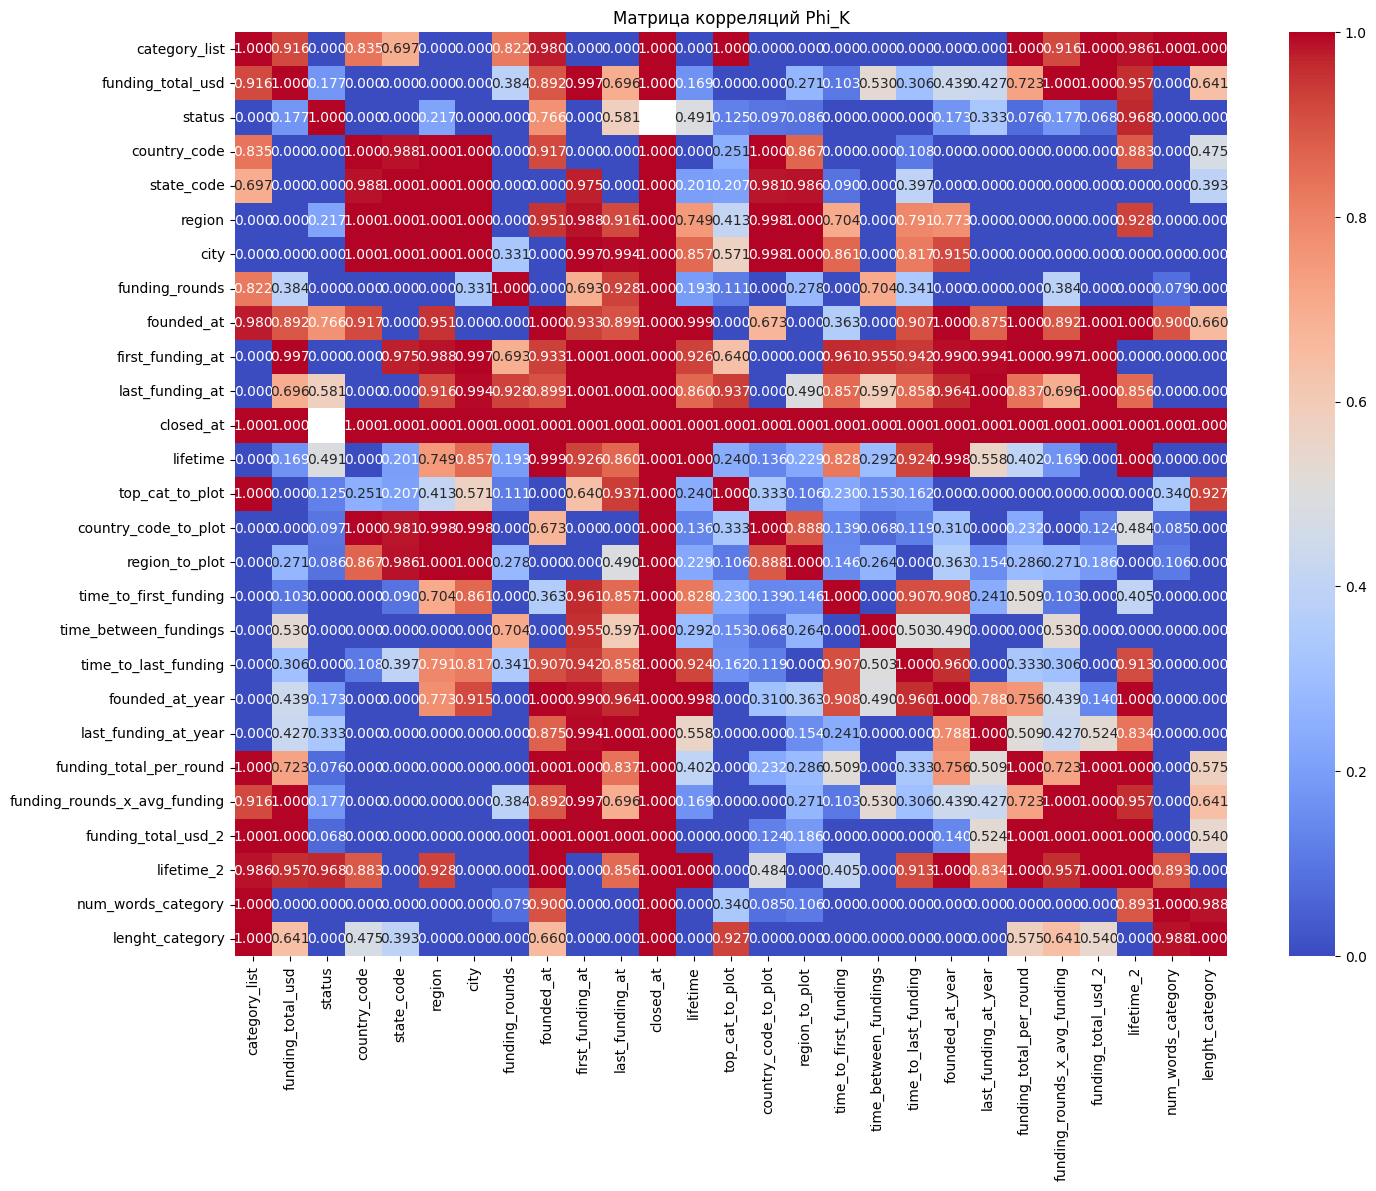

In [46]:
# Построение тепловой карты методом sns.heatmap()
plt.figure(figsize=(16, 12))
sns.heatmap(f_corr_matr, annot=True, cmap='coolwarm', fmt='.3f')
#plt.xticks(rotation=45)
plt.title('Матрица корреляций Phi_K')
plt.show()

**Теперь построим корреляционную матрицу для каждого отдельного значения целевого признака**

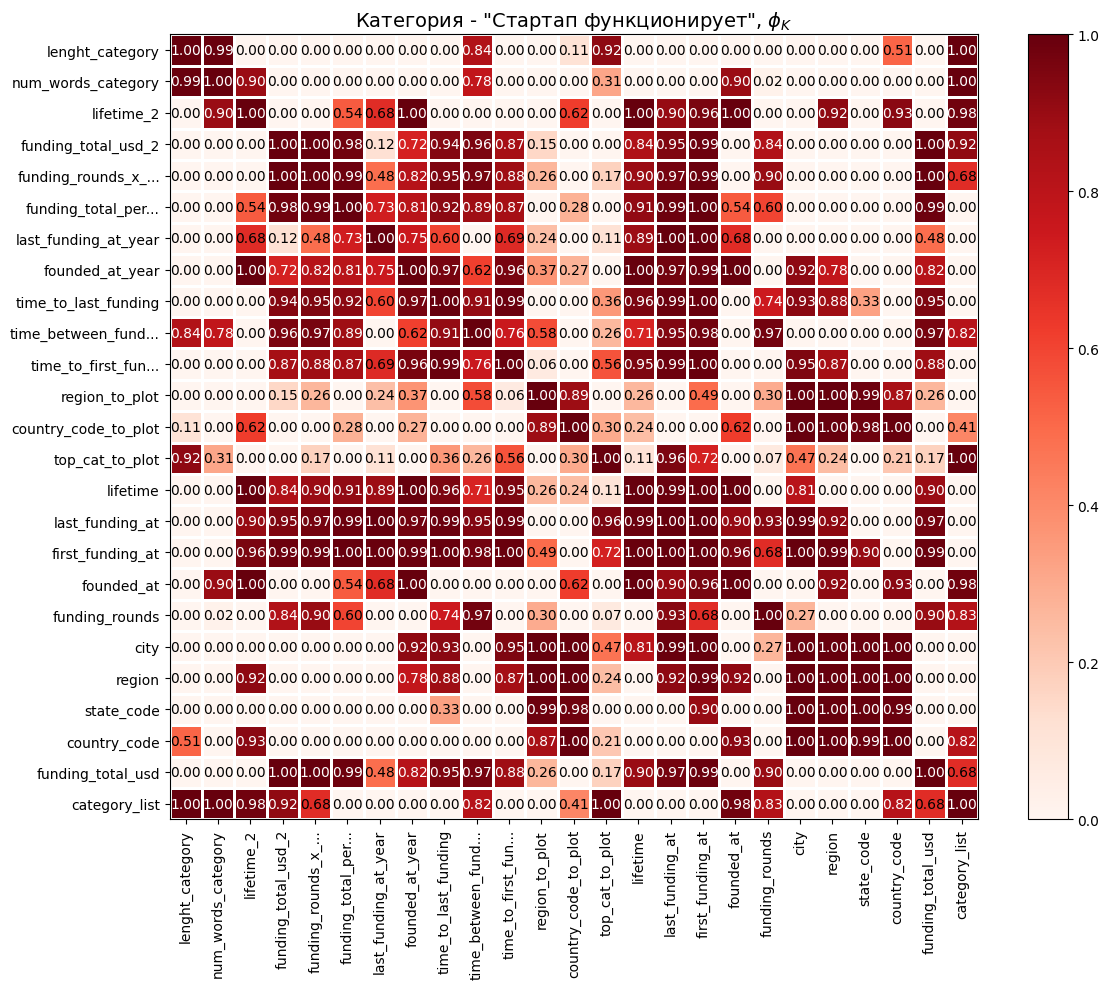

In [47]:
phik_overview_1category = phik_matrix(
    df_train_small[df_train_small['status']=='operating']
    .drop(['status'],axis=1), 
    interval_cols=interval_cols, bins=100
)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Категория - "Стартап функционирует", $\phi_K$',
    fontsize_factor=1,
    figsize=(12, 10)
) 

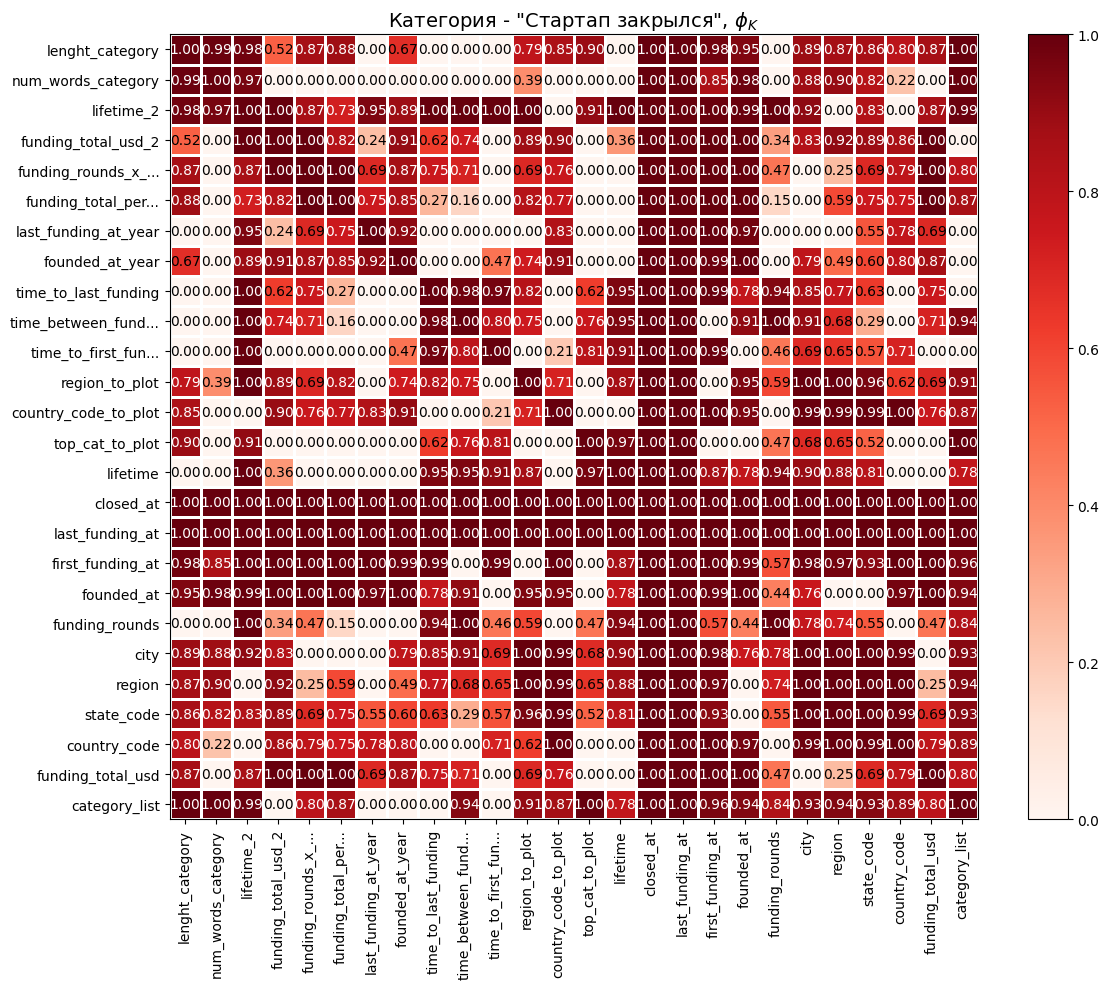

In [48]:
phik_overview_2category = phik_matrix(
    df_train_small[df_train_small['status']=='closed']
    .drop(['status'],axis=1), 
    interval_cols=interval_cols, bins=100
)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Категория - "Стартап закрылся", $\phi_K$',
    fontsize_factor=1,
    figsize=(12, 10)
) 

Шкала Чеддока используется для оценки силы связи коэффициентов корреляции - другими словами величина коэффициента корреляции показывает силу связи. Используется следующая таблица для оценки силы связи:

- 0 - 0.3 - очень слабая
- 0.3 - 0.5 - слабая
- 0.5 - 0.7 - средняя
- 0.7 - 0.9 - высокая
- 0.9 - 1 - очень высокая

Из-за мультиколлинеарности коэффициенты модели могут стать неустойчивыми и в целом скажется на работе моделей. Сложнее будет интерпретировать ее.

**Примем значение 0.75 выше, которого будем считать, что наблюдается мультиколинеальность - очень высокая.** 

- `region_to_plot` и `country_code_to_plot` имеет очень высокую корреляцию с самым большим количеством остальных признаков. Принимаем решение его исключить из выборки. Логично, ведь расположение региона напрямую связано со страной.
- построим потом повторно матрицы корреляции после исключения признака.

In [49]:
df_train.sample()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,time_between_fundings,time_to_last_funding,founded_at_year,last_funding_at_year,funding_total_per_round,funding_rounds_x_avg_funding,funding_total_usd_2,lifetime_2,num_words_category,lenght_category
25810,SN Mobile Technology,Mobile Games,1975141.0,operating,KOR,11,Seoul,Seoul,1,2007-06-03,...,0,2595,2007,2014,1975141.0,1975141.0,3.901182e+12,14938225,1,12


<a id='Step5.3'></a>
<h4><b> 5.3 Отбор финального набора обучающих признаков<a class="tocSkip"></h4>

- `name` - ключ
- `state_code` - мультиколлинеарный признак  
- `city` - мультиколлинеарный признак 
- `region` - мультиколлинеарный признак 
- `founded_at` - во избежание утечки целевой переменной
- `closed_at` - отсутствует в тестовой выборке
- `category_list` - укрупнили 
- `first_funding_at` - мультиколлинеарный признак
- `last_funding_at`
- `time_to_first_funding`
- `funding_total_per_round`
- `time_between_fundings`

In [50]:
columns_to_drop = ['name', 'state_code', 'city', 
                   'founded_at', 'closed_at', 'region_to_plot', 
                  'time_between_fundings', 'time_to_last_funding', 'funding_rounds_x_avg_funding',
                  'first_funding_at', 'last_funding_at', 'founded_at_year', 'funding_total_usd', 
                   'funding_total_per_round', 'num_words_category', 'lenght_category', 'region', 'category_list', 'lifetime', 'time_to_first_funding', 'country_code']

In [51]:
df_train_for_model = df_train.drop(columns_to_drop, axis=1)
df_train_for_model_small, _ = train_test_split(
    df_train_for_model,
    train_size=500,
    stratify=df_train_for_model['status'],
    random_state=RANDOM_STATE
)

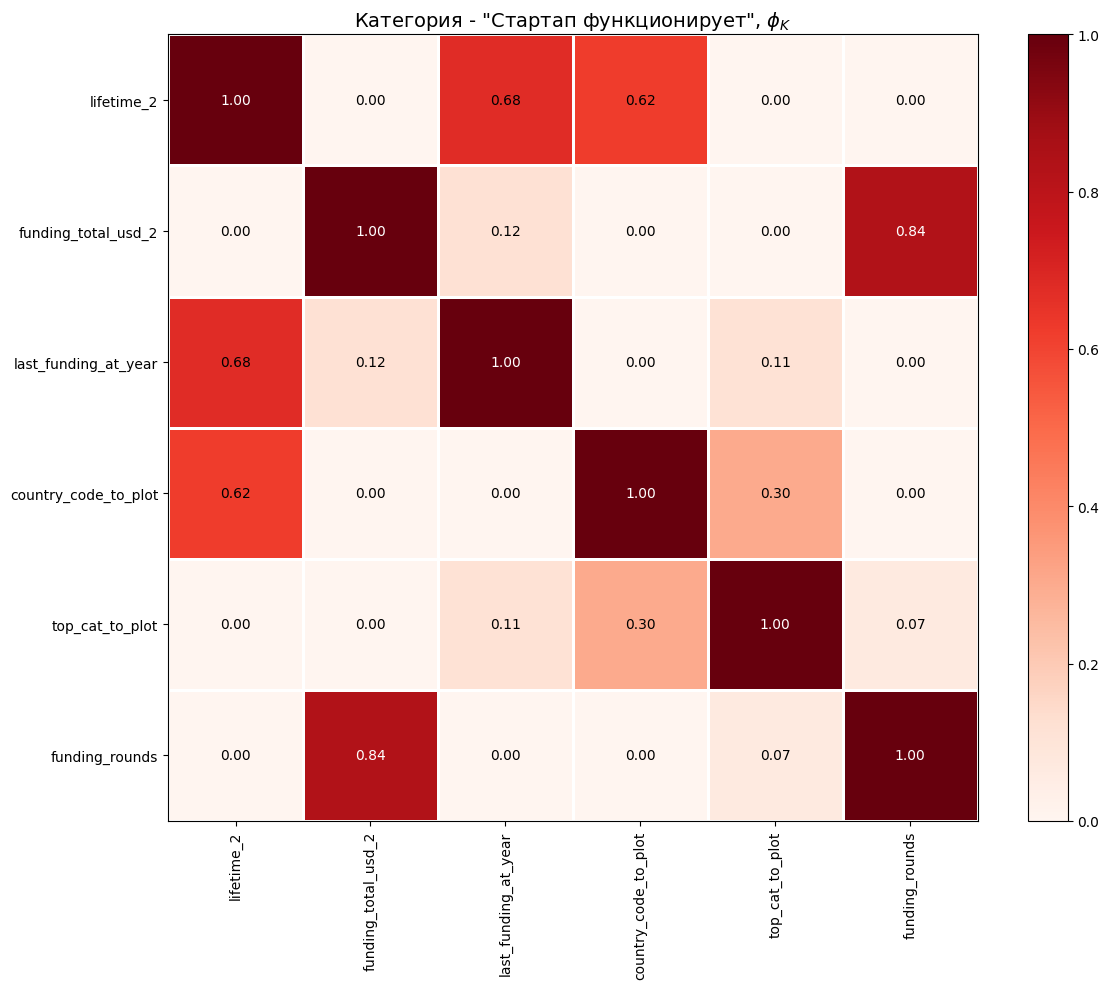

In [52]:
phik_overview_1category = phik_matrix(
    df_train_for_model_small[df_train_for_model_small['status']=='operating']
    .drop(['status'],axis=1), 
    interval_cols=interval_cols, bins=100
)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Категория - "Стартап функционирует", $\phi_K$',
    fontsize_factor=1,
    figsize=(12, 10)
) 

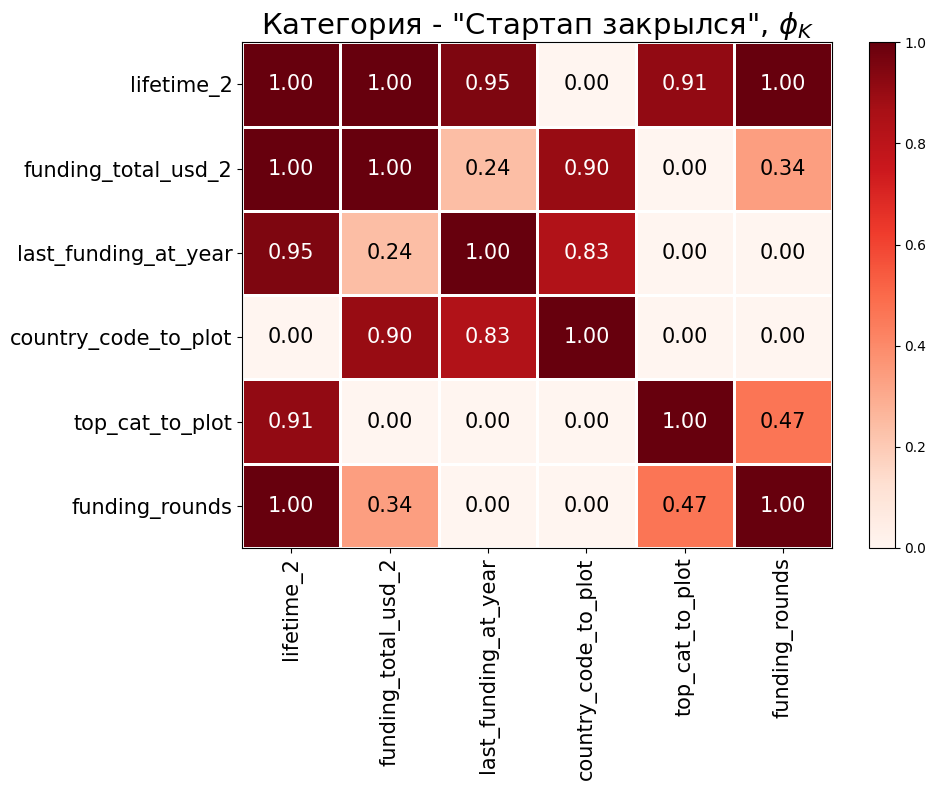

In [53]:
phik_overview_2category = phik_matrix(
    df_train_for_model_small[df_train_for_model_small['status']=='closed']
    .drop(['status'],axis=1), 
    interval_cols=interval_cols, bins=100
)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Reds',
    title=r'Категория - "Стартап закрылся", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(10, 8)
) 

In [54]:
df_train_for_model.head()

,status,funding_rounds,top_cat_to_plot,country_code_to_plot,last_funding_at_year,funding_total_usd_2,lifetime_2
0,operating,2,other,other,2014,6.866210e+11,8988004
1,operating,4,other,USA,2014,1.843416e+15,22543504
2,operating,3,Biotechnology,USA,2014,1.257155e+15,19210689
3,operating,3,Health Care,Other,2014,4.950625e+14,26152996
4,operating,1,other,USA,2012,9.000000e+12,7789681


<a id='Step5.3'></a>
<h4><b> 5.3 Вывод по разделу<a class="tocSkip"></h4>

- Признаки `city, region, state_code, country_code` сильно коррелируют между собой, поскольку они описывают разные уровни местоположения компании. Оставим только укрупненную категорию по `country_code`. Мультиколлинеарность между признаками state_code, country_code, city, region (корреляция = 1).
- `funding_total_usd` и `lifetime` коррелируют между собой - чем дольше компания существует - тем больше финансирования получит суммарно
- `funding_rounds` так же коррелирует с `funding_total_usd` и `lifetime` - чем больше времени компания существует, тем больше раундов финансирования пройдет, так и получит больше денег
- Целевой признак `Стартап закрылся` имеет среднюю корреляцию с `lifetime`. Логично, что чем меньше лайфтайм, тем выше шанс что стартап закрылся.

**- Убрали из финального набора данных признаки, которые имеют мультиколлинеарность, а также признаки, которые могут вызвать утечку данных**

<a id='Step6'></a>
<h3><b>6. Обучение модели и получение результатов <a class="tocSkip"></h3>

<a id='Step6.1'></a>
<h4><b> 6.1 Подготовка признаков<a class="tocSkip"></h4>

In [55]:
#Переименовываем значения категорий, чтобы не было ошибок для LGBMClassifier
import re
df_train_for_model = df_train_for_model.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [56]:
#Создаим списки с распределением столбов для кодирования

num_columns = df_train_for_model.select_dtypes(include='number').columns.tolist()
ohe_columns = ['top_cat_to_plot', 'country_code_to_plot'] #, 'region'
#Отделим входные признаки от целевого признака
X_train = df_train_for_model.drop(['status'], axis=1)
y_train = df_train_for_model['status'].map({'operating': 0, 'closed': 1})

In [57]:
#Укрупним категории
# Ограничение количества уникальных категорий для ускорения One-Hot Encoding
top_n = 30  # Количество топ категорий для каждого признака
for col in ohe_columns:
    top_categories = X_train[col].value_counts().nlargest(top_n).index
    X_train[col] = X_train[col].apply(lambda x: x if x in top_categories else 'Other')

In [58]:
X_train.sample()

,funding_rounds,top_cat_to_plot,country_code_to_plot,last_funding_at_year,funding_total_usd_2,lifetime_2
29086,1,other,USA,2014,1.000000e+12,6548481


In [59]:
num_columns

['funding_rounds', 'last_funding_at_year', 'funding_total_usd_2', 'lifetime_2']

In [60]:
scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, drop='first')

# обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок 
# для тренировочной выборки сделайте это одной командой
X_train_ohe = ohe.fit_transform(X_train[ohe_columns])
#X_test_ohe = ohe.transform(X_test[ohe_columns])

# сохраните в переменной encoder_col_names список названий новых столбцов 
encoder_col_names = ohe.get_feature_names_out()

# создайте датафрейм из закодированных данных
# передайте названия столбцов из переменной encoder_col_names
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
#X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

# масштабируйте количественные признаки из тренировочной и тестовой выборок 
# для тренировочной выборки сделайте это одной командой
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
#X_test[num_col_names] = scaler.transform(X_test[num_col_names])

# обнулите индексы строк перед объединением числовых и категориальных признаков в датафрейм
X_train = X_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train = pd.concat((X_train[num_columns], X_train_ohe), axis=1)
#X_test = pd.concat((X_test[num_col_names], X_test_ohe), axis=1)
# Отбор признаков с помощью SelectKBest

selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_train, y_train)

# Получение названий выбранных признаков
selected_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]

X_train_final = pd.DataFrame(X_selected, columns=selected_feature_names)

In [61]:
X_train_final.head()

,funding_rounds,last_funding_at_year,funding_total_usd_2,lifetime_2,top_cat_to_plot_E-Commerce,top_cat_to_plot_Games,top_cat_to_plot_Hardware + Software,top_cat_to_plot_Other,top_cat_to_plot_Software,top_cat_to_plot_other,country_code_to_plot_CHN,country_code_to_plot_DEU,country_code_to_plot_ESP,country_code_to_plot_FRA,country_code_to_plot_GBR,country_code_to_plot_IND,country_code_to_plot_ISR,country_code_to_plot_Other,country_code_to_plot_USA,country_code_to_plot_other
0,0.055556,0.973684,7.588847e-10,0.029761,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.166667,0.973684,2.037427e-06,0.074648,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.111111,0.973684,1.389465e-06,0.063612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.111111,0.973684,5.471655e-07,0.086600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000000,0.921053,9.947208e-09,0.025793,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [62]:
# Стратегия кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Определение моделей и их гиперпараметров (исключаем SVC)
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [6, 10]
        }
    }
}

<a id='Step6.2'></a>
<h4><b> 6.2 Обучение модели<a class="tocSkip"></h4>

In [63]:
# Словарь для хранения лучших моделей и их оценок
best_models = {}
best_scores = {}

# Обучение и подбор гиперпараметров для каждой модели
for name, config in models.items():
    print(f"Обучение модели: {name}")
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid_search.fit(X_train_final, y_train)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"Лучшая оценка f1 score: {grid_search.best_score_:.4f}")
    print(f"Лучшие параметры: {grid_search.best_params_}\n")

# Вывод лучших моделей и их F1
print("Лучшие модели и их оценки f1 score:")
for name, score in best_scores.items():
    print(f"{name}: f1 score = {score:.4f}")

Обучение модели: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшая оценка f1 score: 0.8568
Лучшие параметры: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Обучение модели: GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшая оценка f1 score: 0.8659
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Обучение модели: LogisticRegression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшая оценка f1 score: 0.5478
Лучшие параметры: {'C': 10, 'penalty': 'l2'}

Обучение модели: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшая оценка f1 score: 0.8681
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Обучение модели: LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4917, number of ne

<a id='Step6.3'></a>
<h4><b> 6.3 Применение модели на тестовой выборке<a class="tocSkip"></h4>

In [64]:
df_test_for_model = df_test.drop(columns_to_drop, axis=1)

In [65]:
# Ограничение количества уникальных категорий для ускорения One-Hot Encoding
top_n = 30  # Количество топ категорий для каждого признака
for col in ohe_columns:
    #top_categories = df_test_for_model[col].value_counts().nlargest(top_n).index
    df_test_for_model[col] = df_test_for_model[col].apply(lambda x: x if x in top_categories else 'Other')

In [66]:
X_test = df_test_for_model.copy()
X_test_ohe = ohe.transform(df_test_for_model[ohe_columns])
encoder_col_names = ohe.get_feature_names_out()

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_test[num_columns] = scaler.transform(df_test_for_model[num_columns])
X_test = X_test.reset_index(drop=True)
X_test = pd.concat((X_test[num_columns], X_test_ohe), axis=1)

#selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected_test = selector.transform(X_test)

# Получение названий выбранных признаков
selected_indices_test = selector.get_support(indices=True)
selected_feature_names_test = X_test.columns[selected_indices_test]

X_test_final = pd.DataFrame(X_selected_test, columns=selected_feature_names_test)

In [67]:
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
test_pred = best_model.predict(X_test_final)

In [68]:
# Отображаем предсказанные классы в 'operating' и 'closed'
status_mapping = {0: 'operating', 1: 'closed'}
test_pred_labels = pd.Series(test_pred, index=X_test_final.index).map(status_mapping)

In [69]:
# Создаём финальный DataFrame для отправки
result_df = pd.DataFrame({
    'name': df_test['name'],
    'status': test_pred_labels
})

In [70]:
result_df['status']

0        operating
1        operating
2        operating
3        operating
4        operating
           ...    
13120    operating
13121    operating
13122    operating
13123    operating
13124    operating
Name: status, Length: 13125, dtype: object

In [71]:
# Сохраняем файл для отправки
result_df_file_path = "result_df5.csv"
result_df.to_csv(result_df_file_path, index=False)
print(f"Файл для отправки сохранён по пути: {result_df_file_path}")

Файл для отправки сохранён по пути: result_df5.csv


In [72]:
# 6. Сохраняем модель для будущего использования
model_file_path = "best_model5.joblib"
joblib.dump(best_model, model_file_path)
print(f"Модель сохранена по пути: {model_file_path}")

Модель сохранена по пути: best_model5.joblib


<a id='Step7'></a>
<h3><b>7. Анализ важности ее признаков<a class="tocSkip"></h3>

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

In [73]:
explainer = shap.Explainer(best_model.predict, X_train_final.values)

In [74]:
shap_values = explainer(X_train_final[:100])

PermutationExplainer explainer: 101it [00:28,  3.54it/s]                                                               


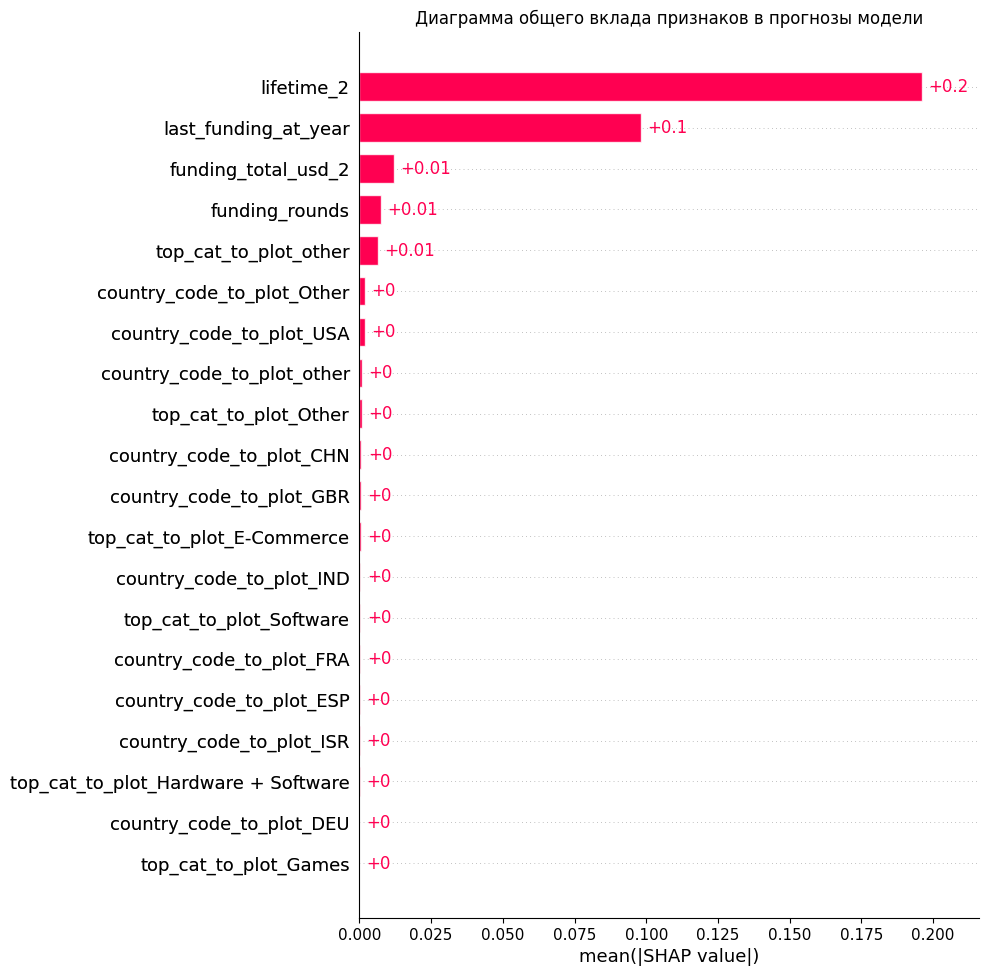

In [75]:
plt.title('Диаграмма общего вклада признаков в прогнозы модели')
shap.plots.bar(shap_values, max_display=30)

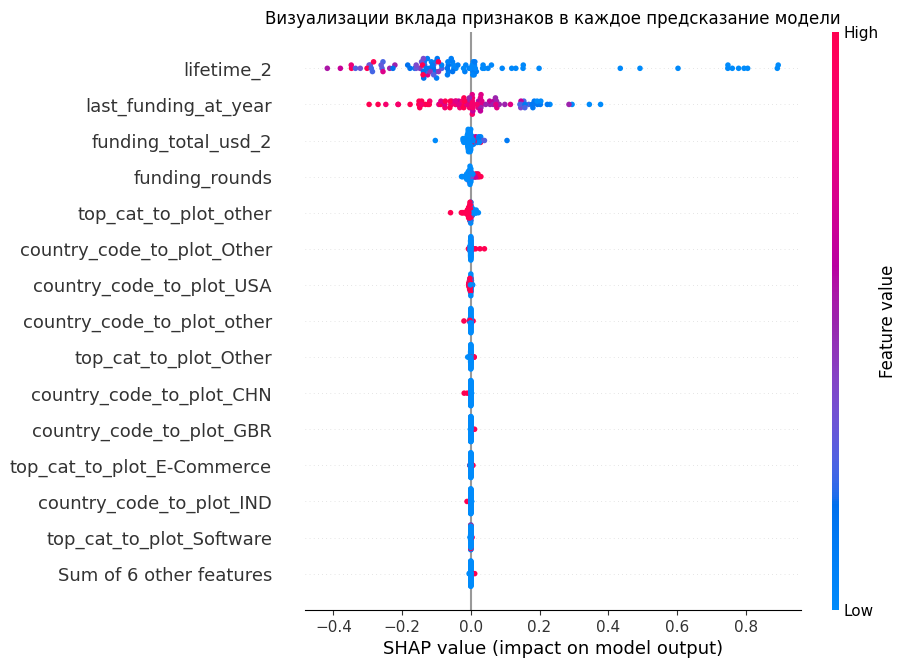

In [76]:
plt.title('Визуализации вклада признаков в каждое предсказание модели')
shap.plots.beeswarm(shap_values, max_display=15)

<a id='Step8'></a>
<h3><b>8. Общий вывод<a class="tocSkip"></h3>

В ходе проекта разработали модель для предсказания успешности стартапа (закроется или нет).

1. Загрузили и обработали данные
   - Получили два датафрейма - тренировочная и тестовая выборка
   - Выборки имели большое количество пропусков, которые заполнили константой для категориальных признаков и медианой для каждой группы для количественных признаков
   - Отсуствуют дубликаты и аномалии
2. Предобработка данный
   - Произвели укрупнение категорий для категориальных признаков `category_list`, `country_code` и `region` - отобрали топ-30 категорий, а остальные заполнили значением Other
3. Исследовательский анализ
   - Визуализировали распределение входных признаков количественных и категориальных
   - Среди категориалных признаков найдены топ категории с сильным дисбалансом - в основном стартапы находились в USA и имели категорию Неизвестно
   - Количественные признаки имеют ненормальное распределение - большие выбивающиеся значения и смещение графика влево
   - Целевой признак имеет явный дисбаланс (больше работающих стартапов, чем закрытых)
4. Создание синтетических признаков
   - Создали новые признаки на основе старых - из даты основания выделили год и месяц, посчитали в днях интервалы между раундами, а также получили новые столбцы объема инвестиций на каждый раунд
5. Корреляционный анализ
   - Использовали phik_matrix для визуализации коррелиции между признаками, а также в зависимости от значения целевого признака
   - Убрали признаки из выборки, которые имеют высокую корреляцию
6. Отбор финальных признаков
   - На основе корреляционного анализа отобрали признаки и закодировали категориальные и количественные
   - При помощи SelectorKbest отобрали лучшие признаки и подготовили финальный датасет для модели
7. Обучение модели
   - Для решения задачи выбрали 6 моделей
   - По итогам обучения выбрали лучшую модель и применили на тестовую выборку
8. Анализ важности признаков
   - При помощи SHAP визуализировали важность признаков для работы модели. Самым важным оказался `lifetime`

**Для ревьюера**

Испробовал разные модели и параметры, на другой компьютере помощнее обучал через пайплайн и гиперпараметры range() использовал. Выше 0.72 так и не подобралась модель никакая.
Исключал и добавлял разные признаки, синтетические признаки использовал в разной комбинации. Разные Scalerы для количественных признаков)

нужен совет куда не туда делаю) Спасибо!

UPD: Нашел признаки, получит на кагле 0,86!